In [3]:
import sys
import os
sys.path.append('./src')
os.chdir(os.path.dirname(sys.path[0]))

# mesa imports
from mesa_geo import GeoAgent, GeoSpace
from mesa.time import BaseScheduler, RandomActivation, SimultaneousActivation
from mesa import datacollection
from mesa import Model, Agent

# language model imports
import re
import torch
from transformers import pipeline
import networkx as nx
import openai

# shapely imports
from shapely.geometry import Polygon, Point, LineString
import shapely

# data analysis imports
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import copy
import time


# Configuration Data and Files
import configparser
from scipy import stats

# plotting imports
import matplotlib as plt

In [278]:


# Prefix for config data
#os.chdir(os.path.dirname(sys.path[0]))
config_file_path_prefix = './config/'


# parser viz config data
viz_ini_file = 'vizparams.ini'

parser_viz = configparser.ConfigParser()
parser_viz.read(config_file_path_prefix + viz_ini_file)

default_section = parser_viz['DEFAULT_PARAMS']


# parser disease config data

disease_params_ini = 'diseaseparams.ini'
parser_dis = configparser.ConfigParser()
parser_dis.read(config_file_path_prefix + disease_params_ini)
incubation = parser_dis['INCUBATION']


# NPI config data


npi_params_ini = 'NPI.ini'
parser_npi = configparser.ConfigParser()
parser_npi.read(config_file_path_prefix + npi_params_ini)




# school config data
school_params_ini = 'schoolparams.ini'
parser_school = configparser.ConfigParser()
parser_school.read(config_file_path_prefix + school_params_ini)
population_config = parser_school['SCHOOL_POPULATION']
school_intervention_params = parser_school['INTERVENTION']





# infectious curve config
###################################### 
# based on gamma fit of 10000 R code points

shape, loc, scale = (float(incubation['shape']), float(incubation['loc']), float(incubation['scale']))

# infectious curve
range_data = list(range(int(incubation['lower_bound']), int(incubation['upper_bound']) + 1))
infective_df = pd.DataFrame(
    {'x': range_data,
     'gamma': list(stats.gamma.pdf(range_data, a=shape, loc=loc, scale=scale))
    }
)
#########################################

In [2]:
language_model = pipeline(model="declare-lab/flan-alpaca-xl", device="cuda:0")

key_path = "openai_api_key"
#openai.organization = "org-D3T7qkglEsZGgYNCoTz3Uocx"
with open(key_path, "r") as f:
    api_key = f.readline()
openai.api_key = api_key

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
sd_cities = """
Alpine
Bonita
Bonsall
Borrego Springs
Boulevard
Camp Pendleton
Campo
Cardiff By The Sea
Carlsbad
Chula Vista
Coronado
Del Mar
Descanso
Dulzura
El Cajon
Encinitas
Escondido
Fallbrook
Guatay
Imperial Beach
Jacumba
Jamul
Julian
La Jolla
La Mesa
Lakeside
Lemon Grove
Mount Laguna
National City
Oceanside
Pala
Palomar Mountain
Pauma Valley
Pine Valley
Potrero
Poway
Ramona
Ranchita
Rancho Santa Fe
San Diego
San Luis Rey
San Marcos
San Ysidro
Santa Ysabel
Santee
Solana Beach
Spring Valley
Tecate
Valley Center
Vista
Warner Springs
"""

In [4]:
sd_cities = sd_cities.split()

In [5]:
agent_N = 10
agent_age = np.random.choice(np.arange(6,30), agent_N)
agent_gender = np.random.choice(['male', 'female'], agent_N)
agent_home = np.random.choice(sd_cities, agent_N)

synthatic_background = pd.DataFrame({'age': agent_age,
                    'gender': agent_gender,
                    'home': agent_home})

In [6]:
synthatic_background

,age,gender,home
0,17,male,Diego
1,11,female,Julian
2,11,female,Valley
3,13,male,Oceanside
4,14,female,Lemon
5,18,female,Rey
6,18,female,Campo
7,7,male,Palomar
8,8,male,El
9,26,male,Jacumba


In [146]:
def generate_text(prompt_background, prompt_text, use_openai = False, model_version = "gpt-3.5-turbo"):
    if use_openai:
        print("using openai "+model_version)
        completion = openai.ChatCompletion.create(
            model=model_version,
            messages=[
            {"role": "system", "content": prompt_background},
            {"role": "user", "content": prompt_text}
            ]
            )

        return completion.choices[0].message['content']
    else:
        # merge background and question for simple model
        prompt = prompt_background + prompt_text
        return language_model(prompt, do_sample=True, min_length=10, max_length=len(prompt)+128)[0]["generated_text"]

In [256]:
def get_rating(rating_str):
    """
    extracts a rating from a string.
    
    rating_str: The string to extract the rating from.
    
    returns:
    int: The rating extracted from the string, or None if no rating is found.
    """
    nums = [int(i) for i in re.findall(r'(?<![A-Za-z0-9.])[0-9](?![0-9:])', rating_str)]
    
    if len(nums)>0:
        return min(nums)
    else:
        return None

In [279]:
import transmission_rate as trans_rate

In [321]:
class Human(GeoAgent):
    '''
    A simple geo-agent that each step moves in the range of [-5,5) and greets all agents within 2 units
    unique_id: the unique_id of the agent
    model: the model that the agent belongs to
    shape: the spatial shape of the agent
    '''
    
    
    
    MEMORY_LIMIT=3
    
    
    
    def __init__(self, unique_id, model, shape, agent_background, crs=3857):
        super().__init__(unique_id, model, shape, crs)
        self.greeted = False # some attribute to indicate if one agent has ever greeted another agent in its life-span
        
        # coordinate attributes
        # eventhough it is not ncessary to establish as attributes
        # setting as attribute would enhance data collection efficiency
        # check mesa documentation for more details in the DataCollector page
        self.x = self.geometry.x
        self.y = self.geometry.y
        
        # set up interaction background for language model
        self.background = agent_background
        self.room = None
        
        
        # human agent memory
        self.current_action = None
        self.memory_ratings = []
        self.memories = []
        self.compressed_memories = []
        
        
        
        
        # mask setup
        # defualt to no mask
        self.mask_type = None
        self.mask_passage_prob = trans_rate.return_mask_passage_prob(self.mask_type)
        
        # disease config

        self.health_status = 'healthy'
        prevalence = float(parser_dis['ASYMPTOMATIC_PREVALENCE']['prevalence'])
        self.asymptomatic = np.random.choice([True, False], p = [prevalence, 1-prevalence])
        self.symptoms = False


        # TODO: vaccination should be parameterized (effective rate, etc.)
        self.tested = False
        self.vaccinated = False
        
        self.infective = False
        
        # symptom onset countdown config
        ##########################################
        # From 10000 lognorm values in R
        countdown = parser_dis['COUNTDOWN']
        shape, loc, scale =  (float(countdown['shape']), float(countdown['loc']), float(countdown['scale']))

        lognormal_dist = stats.lognorm.rvs(shape, loc, scale, size=1)

        
        num_days = max(int(countdown['lower_bound']), 
                       min(np.round(lognormal_dist, 0)[0], 
                           int(countdown['upper_bound'])))# failsafe to avoid index overflow
        self.symptom_countdown = int(num_days)
        #######################################
        
        # default breathing attributes for transmission models
        self.breathing_rate = 'resting'
        self.breathing_activity = 'open_windows'
    
        
    def move(self, other_agent=None, move_range=1):
        '''
        update the current location 
        if other_agent is provided agent will move toward the other agent
        else, the agent will move within the random range and greet to all surrounding neighbors with specified greet_dist
        '''
        

        if other_agent:    
            self.update_shape(other_agent.geometry)
        
        
        move_spread = self.room.geometry.intersection(self.geometry.buffer(move_range))
        

        minx, miny, maxx, maxy = move_spread.bounds 

        while True:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))            
            # check if point lies in true area of polygon
            if move_spread.contains(pnt):
                self.update_shape(pnt)
                break
                
                
    def update_memories(self):
        other_agents = [a for a in self.room.occupants if a.unique_id != self.unique_id]
        for agent in other_agents:
            self.memories.append('[Time: {}. Person: {}. Memory: {}]\n'.format(str(self.model.time), 
                                                                               agent.unique_id, 
                                                                               agent.current_action))

                

    def rate_memories(self):


        memory_ratings = []
        for memory in self.memories:
            prompt = "You are {}. You are currently in {}. It is currently {}:00. You observe the following: {}. Give a rating, between 1 and 5, to how much you care about this."
            prompt = prompt.format(self.unique_id, self.room.room_type, self.model.time, memory)
            res = generate_text("", prompt)
            rating = get_rating(res)
            max_attempts = 2
            current_attempt = 0
            while rating is None and current_attempt < max_attempts:
                rating = get_rating(res)
                current_attempt += 1
            if rating is None:
                rating = 0
            memory_ratings.append((memory, rating, res))
        self.memory_ratings = memory_ratings
        
        
    
    
    def compress_memories(self):


        memories_sorted = sorted(self.memory_ratings, key=lambda x: x[1], reverse=True)
        relevant_memories = memories_sorted[:self.MEMORY_LIMIT]
        memory_string_to_compress = '.'.join([a[0] for a in relevant_memories])
        self.compressed_memories.append('[Recollection at Day {}, Time {}:00: {}]'.format(
            self.model.day, 
            self.model.time, 
            memory_string_to_compress))
        
        
        
        
    @staticmethod
    def droplet_infect(infected, uninfected):
        '''
        baseline transmission rate
        '''
        feet_to_meter = 1/3.2808
        distance = infected.geometry.distance(uninfected.geometry)*feet_to_meter
        
        # normalize symptom countdown value to infectious distribution value
        # 0 being most infectious
        # either -10 or 8 is proven to be too small of a chance to infect others, thus covering asympotmatic case
        
        countdown_norm = min(int(incubation['upper_bound']), max(int(incubation['lower_bound']), 0 - infected.symptom_countdown))
        transmission_baseline = infective_df[infective_df['x'] == countdown_norm]['gamma'].iloc[0]

     
        # Use Chu distance calculation ## see docs
        chu_distance_multiplier = 1/2.02
        distance_multiplier = (chu_distance_multiplier)**distance                                                        

        
        # approximate student time spent breathing vs talking vs loudly talking
        # upperbound baseline (worst case) for breathing activity is moderate_excercise and talking loud
        base_bfr = trans_rate.return_breathing_flow_rate('moderate_exercise')
        base_eai = trans_rate.return_exhaled_air_inf('talking_loud')
        
        
        inf_bfr_mult = trans_rate.return_breathing_flow_rate(infected.breathing_rate)/base_bfr 
        inf_eai_mult = trans_rate.return_exhaled_air_inf(infected.breathing_activity)/base_eai
        
        uninf_bfr_mult = trans_rate.return_breathing_flow_rate(uninfected.breathing_rate)/base_bfr 
        
        # take average of breathing flow rate of two agents
        bfr_multiplier = np.mean([inf_bfr_mult, uninf_bfr_mult])
        # we dont think the uninfected air exahale rate should be a factor here 
        breathing_type_multiplier = bfr_multiplier*inf_eai_mult
        
        

        # Mask Passage: 1 = no masks, .1 = cloth, .05 = N95
        mask_multiplier = np.mean([infected.mask_passage_prob, uninfected.mask_passage_prob])

            


        return transmission_baseline * distance_multiplier * breathing_type_multiplier * mask_multiplier 

                        
    def __check_same_room(self, other_agent):
        '''
        check if current agent and other agent is in the same room
        
        the purpose of this function is to make sure to eliminate edge cases that one agent near the wall of its room
        infects another agent in the neighboring room
        
        this is at this iteration of code only implemented for class purpose, as unique id check is way more efficient
        
        later implementation should add attribute to human agent for current room
        
            other_agent: other agent to check
            returns: boolean value for if the two agents are in the same room
        '''
        return (self.room.unique_id == other_agent.room.unique_id)

    


    
    def update_shape(self, new_shape):
        self.geometry = new_shape
        self.x = self.geometry.x
        self.y = self.geometry.y
    
    def step(self):
        
        # memeory tracking is very time consuming
        if self.model.keep_memory:
            self.update_memories()
            self.rate_memories()
            self.compress_memories()
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()
    
    def advance(self):
        # greet near by agents 
        
        max_infect_dist = 30
        
        neighbors = self.model.grid.get_neighbors_within_distance(self, max_infect_dist)
        # just check in loop
        #neighbors = [neighbor for neighbor in neighbors if neighbor.unique_id != self.unique_id]
        
        
        if self.health_status == 'exposed' and self.infective:
            for neighbor in neighbors:
                if issubclass(type(neighbor), Human) and self.__check_same_room(neighbor) :
                    if neighbor.unique_id != self.unique_id and (neighbor.health_status == 'healthy'):                   
                        # Call Droplet transmission function
                        temp_prob = self.droplet_infect(self, neighbor)
                        infective_prob = np.random.choice ([True, False], p = [temp_prob, 1-temp_prob])
                        if infective_prob and not neighbor.vaccinated:
                            neighbor.health_status = 'exposed'

          
    
    

    

In [4]:
####### UNFINISHED CLASS



class Agency(Agent):
    
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.human = []
        self.room = []
    
    def get_agents(self):
        # get all human agents and room agents from model

        
        for a in self.model.grid.agents:
            if issubclass(type(a), Human):
                self.human.append(a)
            elif issubclass(type(a), Room):
                self.room.append(a)
            else:
                continue
                
    def step(self):
        if len(self.human) == 0:
            self.get_agents()
        
        self.exposed = [a for a in self.human if a.symptoms]
        
        strat = self.plan()
        
        
        ### TODO: use regex to get strat out
        
                
    def get_avaiable_strats(self):
        #### 
        
        return 
    
    def plan(self):
        prompt_background = "You are San Diego Health and Services Agency"
        
        prompt = "You are monitoring a middle school with potential covid outbreak. "
        prompt += "You know the following of the school: "
        
        ### # of personal
        prompt += "The total number of students and staff in the school is {}. ".format(len(self.human))
        
        ### # showing symptom
        prompt += "There are now {} people showing covid symptom. ".format(len(self.exposed))
        
        ### hvac info
        prompt += "The current school is running ventilation type  {}. ".format(eval(school_intervention_params['ventilation_type']))
        
        ### ask for advice
        
        prompt += "What is a appropriate why to mitigate covid transmission in this school? Limit your answer to the following options: "
        
        prompt += self.get_avaiable_strats()
        
        
        return generate_text(prompt_background, prompt, use_openai = True, model_version = "gpt-4-32k")

In [322]:
class Room(GeoAgent):
    
    
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    
    
    def __init__(self, unique_id, model, shape, room_type, crs=3857):
        super().__init__(unique_id, model, shape, crs)
        #self.occupants = []
        #self.aerosol_transmission_rate = []
        #self.barrier = barrier_type
        self.room_type = room_type
        #self.seating_pattern = None
        #self.viral_load = 0
        #self.schedule_id = None
        self.activity = "social gathering event"
        self.occupants = []
        # volume
        #self.floor_area = shape.area
        #self.height = 12

        # airflow ventiliation type
        self.environment = eval(school_intervention_params['ventilation_type'])
    
    def step(self):
        #reset location of agents within the room:
        self.occupants = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Human)]
        
        for a in self.occupants:
            a.move(move_range=10)
        
            
        
        occupant_ids = [a.unique_id for a in self.occupants]
        #exposed = [a for a in occupants if a.infective]

        num_occupants = len(self.occupants)
        #num_exposed = len(exposed)

        # assume this is a cafe for now

        prompt = "There are {} people in this location.".format(num_occupants)

        prompt += ' Currently it is {}.'.format(self.model.time)

        agent_descriptions = [f"{agent.unique_id}: {agent.description}" for agent in self.occupants]
        prompt += ' We know the following about people: ' + '. '.join(agent_descriptions)

        #agent_plans = [f"{agent.unique_id}: {agent.plan}" for agent in self.schedule.agents]
        #prompt += ' We know the daily plan about people: '+ '. '.join(agent_plans)

        prompt += 'They can interact with each other. '

        prompt += "What will each person do in the next hour? Use at most 10 words for each person. Choose one action for each person"
        
        action_text = generate_text("This is a {}. Currently there is a {} happening in this room".format(self.room_type, self.activity), prompt, use_openai=True)
        
        print(action_text)
        
        
        action_lst = re.split(r'p[0-9]+: ', action_text)[1:]
        action_ids = copy.deepcopy(occupant_ids)
        
        for i in range(len(action_lst)):
            act = action_lst[i]
            
            # update agent current action
            self.occupants[i].current_action = act
            # let language model to decide who is having social interaction
            
            # maybe formulate based on level of interaction
            print(act)
            action_bool = generate_text("", "Is there social interaction happening in the action: {} Answer only Yes or No.".format(act))

            if 'No' in action_bool:
                if occupant_ids[i] in action_ids:
                    action_ids.remove(occupant_ids[i])
                
                print('No social interaction for this person!')
                continue
            # if no available actable agents, end loop
            if len(action_ids) == 0:
                break
            actor_id = occupant_ids[i]
            prompt = "The action of {} is: {}. Out of {}, who are interacting with {}. Choose one person.".format(actor_id, 
                                                                                 act, 
                                                                                 ' '.join(action_ids), 
                                                                                 actor_id)

            # let language model decide the actors in this action
            actors_text = generate_text("", prompt)
            
            print("THE ACTORS ARE: ")
            agent_ids = re.findall(r'p[0-9]+', actors_text)
            for agent_id in agent_ids:
                if agent_id in action_ids:
                    action_ids.remove(agent_id)
              
    
            # if more than one agent in action text
            # bring them together physically
            print(agent_ids)
            if len(agent_ids) > 1:
                # get agent objects from agent_ids
                agents = [a for a in self.occupants if a.unique_id in agent_ids] 
                
                # move all agents to location of first agent in list
                for a in agents[1:]:
                    a.move(agents[0])
            
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
        
        
    def advance(self):
        """
            aerosal transmission model
        """
        
        #### add aerosol
        self.model.grid._recreate_rtree() 
 
        exposed = [a for a in self.occupants if a.infective]

        num_occupants = len(self.occupants)
        num_exposed = len(exposed)


        exposure_time = 1

        mean_breathing_rate = np.mean([trans_rate.return_breathing_flow_rate(a.breathing_rate) for a in self.occupants])
        mean_infectivity = np.mean([trans_rate.return_exhaled_air_inf(a.breathing_activity) for a in self.occupants])
        ACH = trans_rate.return_air_exchange_rate(self.environment)
        floor_area = self.floor_area
        
        
        # TODO: take mean of mask_prob of all human agents in the room
        mask_passage_prob = np.mean([a.mask_passage_prob for a in occupants])
        height = self.height


        transmission_rate = aerosol_new.return_aerosol_transmission_rate(floor_area=floor_area, room_height=height,
        air_exchange_rate=ACH, aerosol_filtration_eff=0, relative_humidity=0.69, breathing_flow_rate=mean_breathing_rate, exhaled_air_inf=mean_infectivity,
        mask_passage_prob=mask_passage_prob)

        transmission_rate *= exposure_time
        transmission_rate *= num_exposed #To be changed to some proportion to get infectious
        


        self.aerosol_transmission_rate.append(transmission_rate)
        
            
        
    def generate_seats(self, N, width):
        
        self.seating_pattern = style
        self.seats = []
        shape = self.geometry
        
        
        # generate grid seating that seperates each student by fixed amount

        center = shape.centroid
        md = math.ceil(N**(1/2))
        pnt = Point(center.x - width*md//2, center.y - width*md//2)
        for i in range(md):
            for j in range(md+1):
                self.seats.append(Point(pnt.x + i*width, pnt.y + j*width))


    


In [323]:

def get_agent_description_prompt(agent):
    prompt = "Your name is {}, you are a {}-years-old {} from {}, CA."
    prompt_text = "Tell me something more about yourself. Use at most 30 words to explain."
    prompt = prompt.format(agent.unique_id, 
                           agent.background['age'], 
                           agent.background['gender'], 
                           agent.background['home'])
    
    return prompt, prompt_text


def get_agent_plan_prompt(agent):


    prompt = "You are {}. The following is your description: {}"
    promp_text = " You just woke up. What is your goal for today? Write it down in an hourly basis, starting at 9:00. Write only one or two very short sentences. Be very brief. Use at most 50 words."
    prompt = prompt.format(agent.unique_id, agent.description)

    return prompt, prompt_text
    


class NaiveModel(Model):
    
    schedule_types = {"Sequential": BaseScheduler,
                  "Random": RandomActivation,
                  "Simultaneous": SimultaneousActivation}
    
    
    def __init__(self, agent_class, background_df, agent_N, init_patient=1, schedule_type="Simultaneous"):
        '''
        initialize the model with a GeoSpace grid
        agent_class: the type of agent you want to initialize in this model
                     normally not an input parameter as models are mostly tied to specific agent types
                     here we want to reuse thi model later
        agent_N: number of agents to intialize the model with
        '''
        self.schedule_type = schedule_type
        self.init_patient = init_patient
        
        
        # mesa required attributes
        self.running = True # determines if model should keep on running
        # should be specified to false when given conditions are met
        
        self.grid = GeoSpace() 
        self.schedule = self.schedule_types[schedule_type](self)
        
        self.time_stamps = ["9:00am","10:00am","11:00am","12:00pm","1:00pm","2:00pm","3:00pm","4:00pm"]   
        self.day = 0
        # init agents
        
        ### hard coded room agents
        # should read school map in next udpate
        coords = ((-10, -10), (-10, 10), (10, 10), (10, -10),(-10, -10))
        room_shape = Polygon(coords)
        
        room_agent = Room(model=self,
                          shape=room_shape,
                          unique_id = "r0",
                          room_type="Ball Room")
        self.grid.add_agents(room_agent)
        self.schedule.add(room_agent)
        
        for i in range(agent_N):
            pnt = Point(np.random.uniform(-10, 10), np.random.uniform(-10, 10))
            
            a = agent_class(model=self, 
                            shape=pnt, 
                            agent_background = background_df.loc[i], unique_id="p" + str(i))
            a.room = room_agent
            
            
            # format prompts for language model
            prompt_background, prompt_text = get_agent_description_prompt(a)
            # generate text
            # add text to agent 
            a.description = generate_text(prompt_background, prompt_text)
            self.grid.add_agents(a)
            self.schedule.add(a)
            
        # generate agent description and plan
        


            
        # do the above for plan (plan prompt requires description text, hence this step must be processed after)
        #plan_prompt = [get_agent_plan_prompt(a) for a in self.schedule.agents]
        #plans = language_model(plan_prompt, do_sample=True, min_length=10, max_length=128)
        #for i, agent in enumerate(self.schedule.agents):
        #    agent.plan = plans[i]["generated_text"]
   

    def add_N_patient(self, N): 
        patients = random.sample([a for a in self.schedule.agents if isinstance(a, Human)], N)
        for p in patients:
            p.health_status = "exposed"
            p.infective = True
        
        
    def step(self, keep_memory=True):
        '''
        step function of the model that would essentially call the step function of all agents
        '''
        # openai RPM is 3 currently
        # running more than 3 steps per minute will run into error
        #if self.schedule.steps != 0:
        #    if not (self.schedule.steps%3):
        #        print("Waiting for OpenAI! Sleep 1 min.")
        #        time.sleep(60)
        
        self.keep_memory = keep_memory
        if not self.schedule.steps:
            self.add_N_patient(self.init_patient)
            
            
        if self.schedule.steps%len(self.time_stamps):
            self.day += 1
            print(self.day)
                
        self.time = self.time_stamps[self.schedule.steps%len(self.time_stamps)]
        self.schedule.step()
        self.grid._recreate_rtree() # this is some history remaining issue with the mesa-geo package
        # what this does is basically update the new spatial location of the agents to the scheduler deliberately

In [324]:
%%time
mobile_model = NaiveModel(Human, synthatic_background, agent_N)

C:\Users\sky\.conda\envs\abm\lib\site-packages\transformers\pipelines\base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: total: 9.47 s
Wall time: 9.6 s


C:\Users\sky\.conda\envs\abm\lib\site-packages\geopandas\plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Axes: >

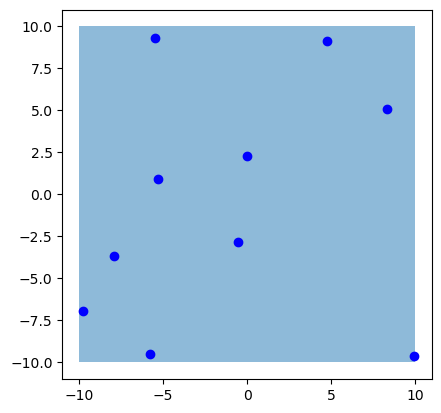

In [325]:
agents = mobile_model.schedule.agents
basemap = gpd.GeoSeries(agents[0].geometry).plot(alpha=0.5)
infective = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:] if agent.infective]))
healthy = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:]  if not agent.infective]))

infective.plot(c="red", ax = basemap)
healthy.plot(c="blue", ax = basemap)

In [326]:
%%time
mobile_model.step()

using openai gpt-3.5-turbo
p0: Write a creative story on their laptop.
p1: Paint a picture using watercolors.
p2: Conduct a science experiment with household objects.
p3: Play the guitar and sing a song for everyone.
p4: Solve math problems on a whiteboard.
p5: Research and plan a future travel destination.
p6: Read a book and discuss it with a friend.
p7: Create a treasure hunt game for their friends to play.
p8: Build a fort using blankets and pillows.
p9: Play a game of basketball with friends at the court.
Write a creative story on their laptop.



C:\Users\sky\.conda\envs\abm\lib\site-packages\transformers\pipelines\base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


No social interaction for this person!
Paint a picture using watercolors.

No social interaction for this person!
Conduct a science experiment with household objects.

No social interaction for this person!
Play the guitar and sing a song for everyone.

THE ACTORS ARE: 
['p2', 'p3']
Solve math problems on a whiteboard.

No social interaction for this person!
Research and plan a future travel destination.

THE ACTORS ARE: 
['p5', 'p6', 'p7']
Read a book and discuss it with a friend.

THE ACTORS ARE: 
['p8', 'p6']
Create a treasure hunt game for their friends to play.

No social interaction for this person!
Build a fort using blankets and pillows.

THE ACTORS ARE: 
['p9', 'p8']
Play a game of basketball with friends at the court.
DOING ROOM THINGS!
CPU times: total: 50 s
Wall time: 59.4 s


In [327]:
mobile_model.schedule.agents[1].memories

['[Time: 9:00am. Person: p1. Memory: Paint a picture using watercolors.\n]\n',
 '[Time: 9:00am. Person: p2. Memory: Conduct a science experiment with household objects.\n]\n',
 '[Time: 9:00am. Person: p3. Memory: Play the guitar and sing a song for everyone.\n]\n',
 '[Time: 9:00am. Person: p4. Memory: Solve math problems on a whiteboard.\n]\n',
 '[Time: 9:00am. Person: p5. Memory: Research and plan a future travel destination.\n]\n',
 '[Time: 9:00am. Person: p6. Memory: Read a book and discuss it with a friend.\n]\n',
 '[Time: 9:00am. Person: p7. Memory: Create a treasure hunt game for their friends to play.\n]\n',
 '[Time: 9:00am. Person: p8. Memory: Build a fort using blankets and pillows.\n]\n',
 '[Time: 9:00am. Person: p9. Memory: Play a game of basketball with friends at the court.]\n']

In [328]:
mobile_model.schedule.agents[1].memory_ratings

[('[Time: 9:00am. Person: p1. Memory: Paint a picture using watercolors.\n]\n',
  3,
  '3 because it is not important to me.'),
 ('[Time: 9:00am. Person: p2. Memory: Conduct a science experiment with household objects.\n]\n',
  3,
  '3/5. I care very much about what p2 is doing and am doing. I am eager to see what she comes up with.'),
 ('[Time: 9:00am. Person: p3. Memory: Play the guitar and sing a song for everyone.\n]\n',
  4,
  '4 (I care a lot). The person is very talented and should be rewarded for performing for everybody.'),
 ('[Time: 9:00am. Person: p4. Memory: Solve math problems on a whiteboard.\n]\n',
  3,
  '3/5 I care about this, as I am currently in the Ball Room and it has been 8 hours since I last left.'),
 ('[Time: 9:00am. Person: p5. Memory: Research and plan a future travel destination.\n]\n',
  3,
  '3/5. I care about this because it is a good reminder to take care of myself and prioritize my tasks.'),
 ('[Time: 9:00am. Person: p6. Memory: Read a book and discuss i

In [329]:
mobile_model.schedule.agents[1].compressed_memories

['[Recollection at Day 0, Time 9:00am:00: [Time: 9:00am. Person: p3. Memory: Play the guitar and sing a song for everyone.\n]\n.[Time: 9:00am. Person: p8. Memory: Build a fort using blankets and pillows.\n]\n.[Time: 9:00am. Person: p1. Memory: Paint a picture using watercolors.\n]\n]']

<Axes: >

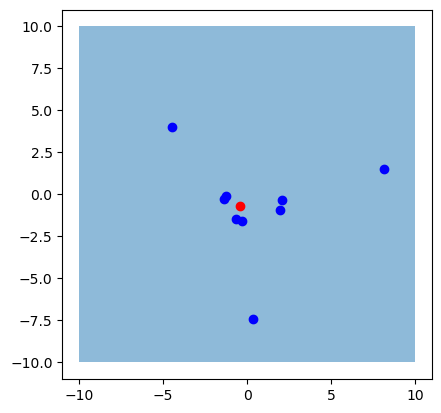

In [330]:
agents = mobile_model.schedule.agents
basemap = gpd.GeoSeries(agents[0].geometry).plot(alpha=0.5)
infective = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:] if agent.infective]))
healthy = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:]  if not agent.infective]))

infective.plot(c="red", ax = basemap)
healthy.plot(c="blue", ax = basemap)

In [331]:
%%time
mobile_model.step(keep_memory=False)

1
using openai gpt-3.5-turbo
p4: Watching a movie with friends.
p9: Playing sports at a nearby park.
p8: Playing Minecraft on his Xbox.
p7: Going on an adventure and playing games.
p6: Reading a book or watching a movie.
p5: Studying marketing and planning her next travel destination.
p0: Writing creatively or exploring the outdoor surroundings.
p2: Engaging in science and technology experiments.
p3: Listening to music and building relationships with others.
p1: Exploring and trying out new creative activities
Watching a movie with friends.



C:\Users\sky\.conda\envs\abm\lib\site-packages\transformers\pipelines\base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


THE ACTORS ARE: 
['p4', 'p9', 'p8', 'p7']
Playing sports at a nearby park.

THE ACTORS ARE: 
['p6', 'p9']
Playing Minecraft on his Xbox.

THE ACTORS ARE: 
['p5', 'p8', 'p8']
Going on an adventure and playing games.

THE ACTORS ARE: 
['p3', 'p7']
Reading a book or watching a movie.

No social interaction for this person!
Studying marketing and planning her next travel destination.

No social interaction for this person!
Writing creatively or exploring the outdoor surroundings.

No social interaction for this person!
Engaging in science and technology experiments.

No social interaction for this person!
Listening to music and building relationships with others.

THE ACTORS ARE: 
['p2', 'p3']
Exploring and trying out new creative activities
THE ACTORS ARE: 
['p1']
DOING ROOM THINGS!
CPU times: total: 6.95 s
Wall time: 14.9 s


<Axes: >

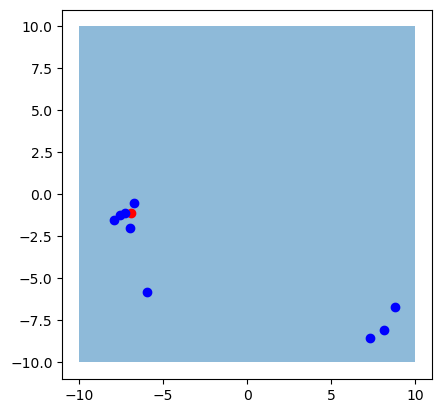

In [332]:
agents = mobile_model.schedule.agents
basemap = gpd.GeoSeries(agents[0].geometry).plot(alpha=0.5)
infective = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:] if agent.infective]))
healthy = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents[1:]  if not agent.infective]))

infective.plot(c="red", ax = basemap)
healthy.plot(c="blue", ax = basemap)